# Manufactured solution for BP3-like problem


The manufactured solution is going to exactly solve the following problem:

$$
\begin{aligned}
    -\frac{\partial\sigma_{ij}(\boldsymbol{u})}{\partial x_i} &= 0 & \text{ in } & \Omega \\
    \sigma_{ij} &= c_{ijkl} \frac{\partial u_k}{\partial x_l} & \text{ in } & \Omega \\
    u_i &= u_i^* & \text{ on } & \Gamma_D \\
    u_1^- - u_1^+ &= 0 & \text{ on } & \Gamma_F \\
    u_2^- - u_2^+ &= -S & \text{ on } & \Gamma_F \\
    -(\tau^0 + \tau) &= (\sigma_n^0-\sigma_n)f(V,\psi) + \eta V & \text{ on } & \Gamma_F \\
    \frac{d\psi}{dt} &= g(V,\psi) + s(\vec x, t) & \text{ on } & \Gamma_F \\ 
    \frac{dS}{dt} &= V & \text{ on } & \Gamma_F
\end{aligned}
$$
where
$$
\begin{aligned}
    f(V, \psi) &= a \cdot \mathrm{asinh}\left(\frac{V}{2V_0} \exp\left(\frac{\psi}{a}\right)\right) \\
    g(V, \psi) &= \frac{b V_0}{L} \left(\exp\left(\frac{f_0-\psi}{b}\right) - \frac{|V|}{V_0}\right) \\
    s(\vec{x}, t) &= - g(V^*, \psi^*) + \frac{d\psi^*}{dt} \\
    \tau &= -\sigma_{12} \\
    \sigma_n &= \sigma_{11}
\end{aligned}
$$

In [1]:
from sympy import *
init_printing()

We first define symbols and general functions, which are going to be specified later.

In [2]:
x, y, t = symbols('x y t')
te, tw = symbols('t_e t_w')
V0, Vp = symbols('V_0 V_p')
a, sn, eta = symbols('a sigma_n eta')
K = Function('K')(t)
V_star = Function('V^*')(y, t)
tau_star = Function('tau^*')(y, t)
tau_pre = Function('tau^0')(y)
sn_star = symbols('sigma_n^*')
sn_pre = Function('sigma_n^0')(y)
E, nu = symbols('E nu', real=True, positive=True)
lamda = E*nu/((1-2*nu)*(1+nu))
mu = E/(2*(1+nu))

$\psi^*$ is the state variable.

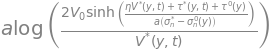

In [3]:
psi_star = a * log((2*V0/V_star) * sinh((tau_star + tau_pre + eta*V_star)/(a*(sn_star - sn_pre))))
psi_star

We need the time derivative $\frac{d\psi^*}{dt}$

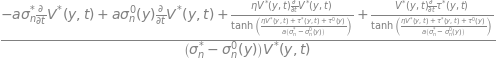

In [4]:
psi_star.diff(t).simplify()

$u_i^*$ is solution for the displacement.

In [5]:
k = symbols('k', real=True, positive=True)
f = K*x*exp(-k*x)
phi = cos(k*y)*f
phi

In [6]:
sxx = phi.diff(y, 2)
syy = phi.diff(x, 2)
sxy = -phi.diff(x).diff(y)
exx = (sxx - nu/(1-nu)*syy)*(1-nu**2)/E
eyy = (syy - nu/(1-nu)*sxx)*(1-nu**2)/E
exy = sxy*(1+nu)/E
ux_star = integrate(exx, x)
uy_star = integrate(eyy, y)
ux_star.simplify()

In [7]:
uy_star.simplify()

In [8]:
simplify(ux_star.diff(y) + uy_star.diff(x) - 2*exy)

Let's introduce slip:

In [9]:
uxm_star = ux_star.subs(k, -k)
uym_star = uy_star.subs(k, -k)
uxp_star = ux_star
uyp_star = uy_star

$S^*$ is the on-fault displacement.

In [10]:
S_star_fun = -(uym_star - uyp_star).subs(x, 0).simplify()
S_star_fun

$\tau^*$ is the on fault shear traction.

In [11]:
s21 = mu * (uxm_star.diff(y) + uym_star.diff(x))
tau_star_fun = -s21.subs(x, 0).simplify()
tau_star_fun

Check continuity:

In [12]:
s21 = mu * (uxp_star.diff(y) + uyp_star.diff(x))
tau_star_fun = -s21.subs(x, 0).simplify()
tau_star_fun

$\sigma_n^*$ is the on fault normal stress.

In [13]:
s11 = (lamda + 2*mu) * uxm_star.diff(x) + lamda * uym_star.diff(y)
sn_star_fun = s11.subs(x, 0).simplify()
sn_star_fun

Check continuity:

In [14]:
s11 = (lamda + 2*mu) * uxp_star.diff(x) + lamda * uyp_star.diff(y)
sn_star_fun = s11.subs(x, 0).simplify()
sn_star_fun

Slip-rate $V^*$

In [15]:
V_star_fun = S_star_fun.diff(t)
V_star_fun

Acceleration $\frac{dV^*}{dt}$

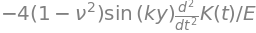

In [16]:
V_star_fun.diff(t)

The following lines define the functions $K$ and necessary time derivatives.

In [17]:
K_fun = 2.0 * (atan((t-te)/tw) + pi/2) / pi
K_fun

In [18]:
K_fun.subs(t, 0)

In [19]:
K_fun.subs(t, te)

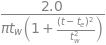

In [20]:
K_fun.diff(t)

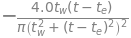

In [21]:
K_fun.diff(t).diff(t).simplify()

## Plot solution

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
y1 = -0.2
y2 = -0.5
y3 = -0.8
mu_val = 3.464**2 * 2.670
v = dict()
v[eta] = 3.464 * 2.670
v[nu] = 0.25
v[E] = 2*mu_val*(1+v[nu])
v[te] = 50
v[tw] = 1
v[k] = float(pi.evalf())
v[V0] = 1.0e-6
v[a] = 0.015
v[sn_pre] = 25 * abs(sin(v[k] * y))
v[tau_pre] = 20 * sin(v[k] * y)
v

In [24]:
v[K] = K_fun.subs(v)
v[K]

In [25]:
V_star_val = V_star_fun.subs(v).simplify()
def V_star_eval():
    def F(Y, T):
        return float(V_star_val.subs(y, Y).subs(t, T).evalf())
    return np.vectorize(F)
V_star_val
S_star_val = S_star_fun.subs(v).simplify()
def S_star_eval():
    def F(Y, T):
        return float(S_star_val.subs(y, Y).subs(t, T).evalf())
    return np.vectorize(F)
S_star_val

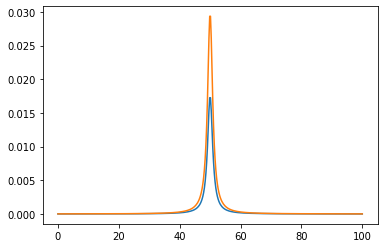

In [26]:
T1 = np.linspace(0, 2*v[te], 400)
plt.plot(T1, V_star_eval()(y1, T1))
plt.plot(T1, V_star_eval()(y2, T1))

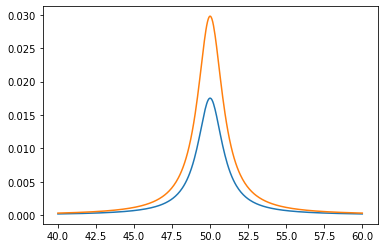

In [27]:
T2 = np.linspace(v[te] - 10*v[tw], v[te] + 10*v[tw], 400)
plt.plot(T2, V_star_eval()(y1, T2))
plt.plot(T2, V_star_eval()(y2, T2))

In [28]:
def tau_pre_eval():
    def F(Y):
        return float(v[tau_pre].subs(y, Y).evalf())
    return np.vectorize(F)
tau_star_val = tau_star_fun.subs(v).simplify()
def tau_star_eval():
    def F(Y, T):
        return float(tau_star_val.subs(y, Y).subs(t, T).evalf())
    return np.vectorize(F)
tau_star_val

In [29]:
sn_star_val = sn_star_fun.subs(v)
def sn_star_eval():
    def F(Y):
        return float(sn_star_val.subs(y, Y).evalf())
    return np.vectorize(F)
sn_star_val

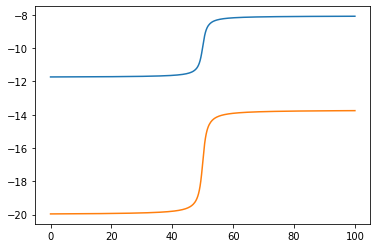

In [30]:
plt.plot(T1, tau_pre_eval()(y1) + tau_star_eval()(y1, T1))
plt.plot(T1, tau_pre_eval()(y2) + tau_star_eval()(y2, T1))

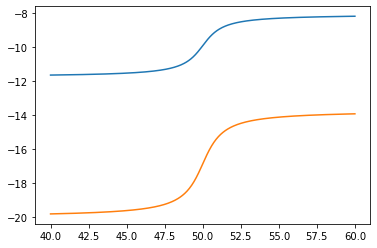

In [31]:
plt.plot(T2, tau_pre_eval()(y1) + tau_star_eval()(y1, T2))
plt.plot(T2, tau_pre_eval()(y2) + tau_star_eval()(y2, T2))

In [32]:
psi_star_val = psi_star.subs(v).subs(tau_star, tau_star_val).subs(sn_star, sn_star_val).subs(V_star, V_star_val)
def psi_star_eval():
    def F(Y, T):
        return float(psi_star_val.subs(y, Y).subs(t, T).evalf())
    return np.vectorize(F)
def dpsidt_star_eval():
    def F(Y, T):
        return float(psi_star_val.diff(t).subs(y, Y).subs(t, T).evalf())
    return np.vectorize(F)

In [33]:
[psi_star_eval()(y2, 0), psi_star_eval()(y2, v[te]), psi_star_eval()(y2, 2*v[te])]

[array(0.7612255), array(0.50877239), array(0.51309766)]

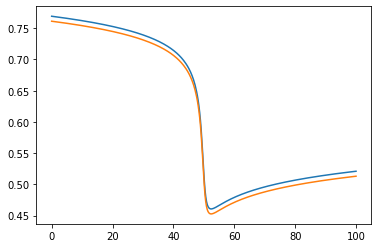

In [34]:
plt.plot(T1, psi_star_eval()(y1, T1))
plt.plot(T1, psi_star_eval()(y2, T1))

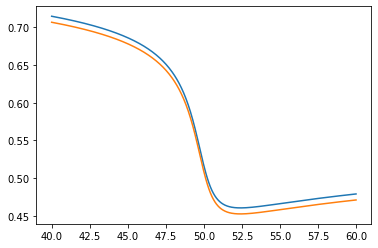

In [35]:
plt.plot(T2, psi_star_eval()(y1, T2))
plt.plot(T2, psi_star_eval()(y2, T2))

## Test time integration

In [36]:
from scipy.integrate import solve_ivp
from scipy.optimize import toms748

In [37]:
y_eval = y2
tau_pre1 = tau_pre_eval()(y_eval)
tau_star1 = lambda t: tau_star_eval()(y_eval, t)
sn_pre1 = float(v[sn_pre].subs(y, y_eval))
psi_star1 = lambda t: psi_star_eval()(y_eval, t)
dpsidt_star1 = lambda t: dpsidt_star_eval()(y_eval, t)
S_star1 = lambda t: S_star_eval()(y_eval, t)
V_star1 = lambda t: V_star_eval()(y_eval, t)
(tau_pre1, tau_star1(0), sn_pre1, psi_star1(0), dpsidt_star1(0), V_star1(0))

(array(-20.),
 array(0.03999467),
 25.0,
 array(0.7612255),
 array(-0.00063192),
 array(1.1917651e-05))

In [38]:
def friction_law(V, sn, psi):
    a = 0.015
    e = np.exp(psi / a)
    f = a * np.arcsinh((V / (2.0 * 1.0e-6)) * e)
    return sn * f

def slip_rate(tau, sn, psi):
    eta = 3.464*2.670/2
    L = 0
    R = -tau / eta
    if L == R:
        return 0.0
    if L > R:
        L, R = R, L
    return toms748(
        lambda V: tau + friction_law(V, sn, psi) + eta * V,
        L,
        R,
        xtol=1e-100)

def state_law(V, psi):
    return 0.02 * 1.0e-6 / 0.2 * (np.exp((0.6 - psi) / 0.02) - np.abs(V) / 1.0e-6)


def y0():
    y0 = np.zeros((2,))
    y0[0] = psi_star1(0)
    y0[1] = S_star1(0)
    return y0


def F(t, y):
    fy = np.ndarray(y.shape)
    psi = y[0]
    V = slip_rate(tau_pre1 + tau_star1(t), sn_pre1, psi)
    fy[0] = state_law(V, psi) - state_law(V_star1(t), psi_star1(t)) + dpsidt_star1(t)
    fy[1] = V
    return fy

In [39]:
t0 = 0
tend = 2*v[te]
result = solve_ivp(F, (t0, tend), y0(), method='RK45', rtol=1e-7, atol=1e-50)
result

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 530
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.71392064e-02, 4.08531270e-01, 4.12245191e+00,
       1.04246702e+01, 1.59221740e+01, 2.05707303e+01, 2.45411863e+01,
       2.79289363e+01, 3.08256539e+01, 3.33062639e+01, 3.54345051e+01,
       3.72640363e+01, 3.88401405e+01, 4.02010162e+01, 4.13789027e+01,
       4.24010279e+01, 4.32904100e+01, 4.40665356e+01, 4.47459313e+01,
       4.53426478e+01, 4.58686706e+01, 4.63342724e+01, 4.67483203e+01,
       4.71185577e+01, 4.74887951e+01, 4.77880639e+01, 4.80873327e+01,
       4.83637577e+01, 4.86240455e+01, 4.88905434e+01, 4.90651693e+01,
       4.92218202e+01, 4.93784711e+01, 4.95203744e+01, 4.96545665e+01,
       4.97894161e+01, 4.99392409e+01, 5.00831349e+01, 5.02270289e+01,
       5.03685195e+01, 5.05214042e+01, 5.07036396e+01, 5.09460547e+01,
       5.11872092e+01, 5.14372177e+01, 5

In [40]:
np.min(np.diff(result['t']))

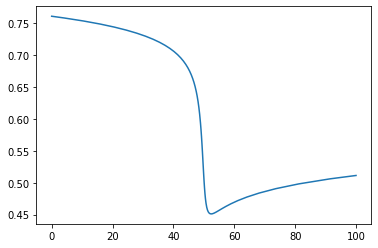

In [41]:
plt.plot(result['t'], result['y'][0])

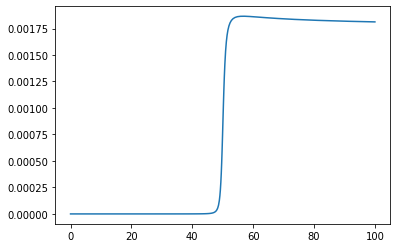

In [42]:
plt.plot(result['t'], np.abs(result['y'][0] - psi_star1(result['t'])))

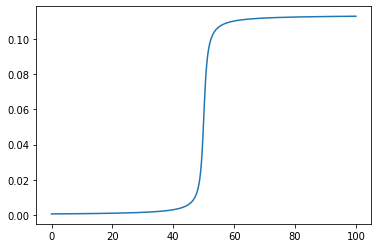

In [43]:
plt.plot(result['t'], result['y'][1])